In [554]:
import pyxdf
import mne
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing (No artifact removal via EOG)

In [555]:
# -- |Data details| --
participant_id = '03'
n_session = 5

# -- |Local parameters|--
epochs_list = [] 

for i in range(1,n_session+1):
    # -- |File import| --
    streams, header = pyxdf.load_xdf(f"Data/sub-P0{participant_id}/ses-S00{str(i)}/eeg/sub-P0{participant_id}_ses-S00{str(i)}_task-Default_run-001_eeg.xdf") #Example Data from Lab Recoder
    
    # -- |EEG data| --
    EEG = [data for data in streams if data['info']['type'] == ['EEG']][0] #From Steam variable this query is EEG data
    raw_data = (EEG["time_series"].T)/1000000 # Convert to volt
    raw_data.shape # It contain with 8 channel of EGG data

    # -- |Channels Information| --
    channels = ['Fz','C3','Cz','C4','Pz','PO7','PO8','EOG'] #Set your target EEG channel name
    info = mne.create_info(
        ch_names= channels,
        ch_types= ['eeg']*(len(channels) - 1) + ['eog'],
        sfreq= 250  #OpenBCI Frequency acquistion
    )

    # -- |Create MNE rawarray| --
    raw_mne = mne.io.RawArray(raw_data, info, verbose=False)

    # -- |Common Average Reference| --
    mne_car = raw_mne.copy().set_eeg_reference('average')

    # -- |Bandpass filter| --
    mne_alpha = mne_car.filter(l_freq=8.0, h_freq=13.0, fir_design='firwin', verbose=False)

    # -- |Events|--
    Events = [data for data in streams if data['info']['type'] == ['Markers']][0]

    event_index = Events["time_series"].T[0] #Get all event marker of experiment 
    event_timestamp = (((Events["time_stamps"].T) - EEG["time_stamps"][0]) *250).astype('int')

    events = np.column_stack((np.array(event_timestamp, dtype = int),
                        np.zeros(len(event_timestamp), dtype = int),
                        np.array(event_index, dtype = int)))

    events_id = { # Set up your event name
        'right': 0,
        'left': 1
    }

    # -- |Epoch Segmentation| --
    epochs = mne.Epochs(mne_alpha, events, 
        tmin= -0.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 3.0,      # final timestamp (10 means set epoch duration 10 second)
        event_id =events_id,
        preload = True,
        verbose=True,
        picks = ['C3','Cz','C4','PO7','Pz','PO8','EOG']
    )

    epochs_list.append(epochs)

epochs = mne.concatenate_epochs(epochs_list)
epochs.set_montage(mne.channels.make_standard_montage('standard_1020'))

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
31 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 876 original time points ...
1 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
31 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 876 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
31 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items a

Number of events,154
Events,left: 75right: 79
Time range,-0.500 – 3.000 s
Baseline,-0.500 – 0.000 s


In [556]:
# Get EEG data and events
X = epochs.get_data(copy=False)
Y = epochs.events[:, -1]

print(f'EEG data shape: {X.shape}')
print(f'events shape  : {Y.shape}')

EEG data shape: (154, 7, 876)
events shape  : (154,)


Computing rank from data with rank=None
    Using tolerance 2e-05 (2.2e-16 eps * 7 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-05 (2.2e-16 eps * 7 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.


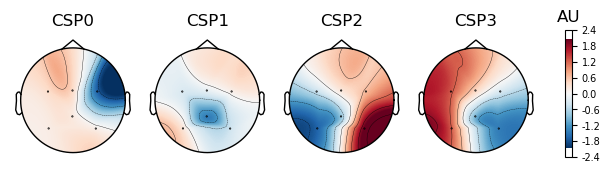

In [557]:
from mne.decoding import CSP
# Initilize CSP
csp = CSP(n_components = 4, norm_trace = False)

# Fit CSP to data 
csp.fit(X,Y)

# Visualize CSP patterns
csp.plot_patterns(epochs.info);

In [558]:
from sklearn.model_selection import train_test_split, cross_val_score
# Transform data into CSP space
X_transformed = csp.transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42)

In [559]:
from sklearn.svm import SVC 
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

clf = Pipeline([('SVM', SVC(kernel='linear'))])  
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
print(report)

Accuracy: 0.6451612903225806
              precision    recall  f1-score   support

       right       0.72      0.68      0.70        19
        left       0.54      0.58      0.56        12

    accuracy                           0.65        31
   macro avg       0.63      0.63      0.63        31
weighted avg       0.65      0.65      0.65        31



# Visualizations

In [560]:
right_MI = epochs['right'].average() # Average all right trials
right_MI

Condition,right
Data kind,average
Timepoints,876 samples
Channels,6 channels
Number of averaged epochs,79
Time range (secs),-0.5 – 3.0
Baseline (secs),-0.500 – 0.000 s


In [561]:
left_MI = epochs['left'].average() # Average all left trials
left_MI

Condition,left
Data kind,average
Timepoints,876 samples
Channels,6 channels
Number of averaged epochs,75
Time range (secs),-0.5 – 3.0
Baseline (secs),-0.500 – 0.000 s


In [562]:
right_electrodes = ['C4','PO8']
left_electrodes = ['C3','PO7']
center_electrodes = ['Cz']

right_MI_R = epochs['right'].average(picks = right_electrodes)
right_MI_L = epochs['right'].average(picks = left_electrodes)
left_MI_R = epochs['left'].average(picks = right_electrodes)
left_MI_L = epochs['left'].average(picks = left_electrodes)

## Time Domain

### Time Series Plot

#### Right Motor Imagery

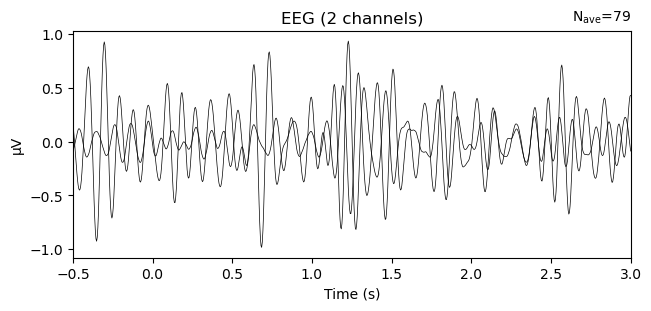

In [563]:
right_MI.plot(picks = right_electrodes, spatial_colors=False);

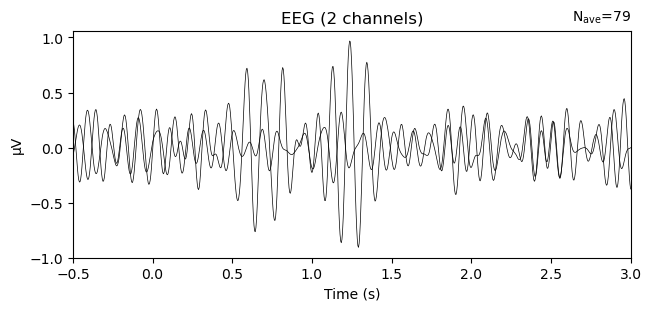

In [564]:
right_MI.plot(picks = left_electrodes, spatial_colors=False);

Need more than one channel to make topography for eeg. Disabling interactivity.


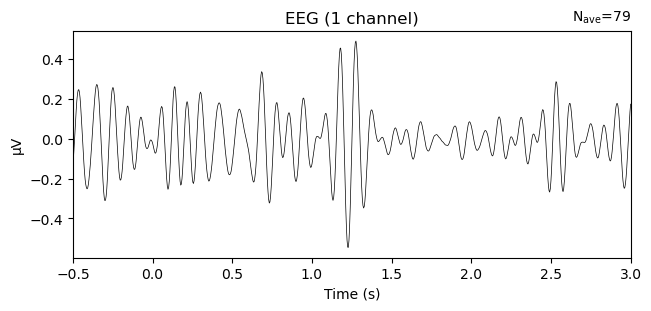

In [565]:
right_MI.plot(picks = center_electrodes, spatial_colors=False);

#### Left Motor Imagery

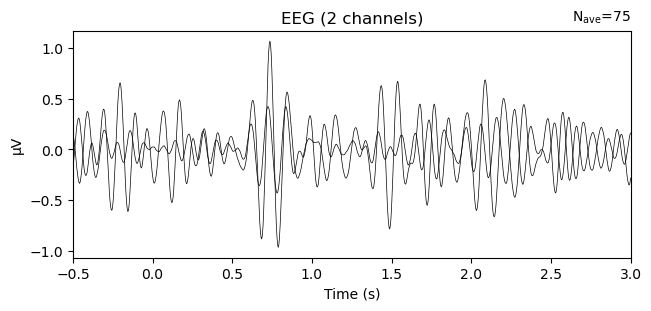

In [566]:
left_MI.plot(picks = right_electrodes, spatial_colors=False);

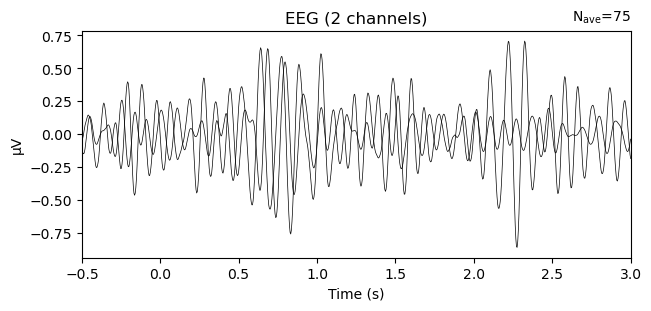

In [567]:
left_MI.plot(picks = left_electrodes, spatial_colors=False);

Need more than one channel to make topography for eeg. Disabling interactivity.


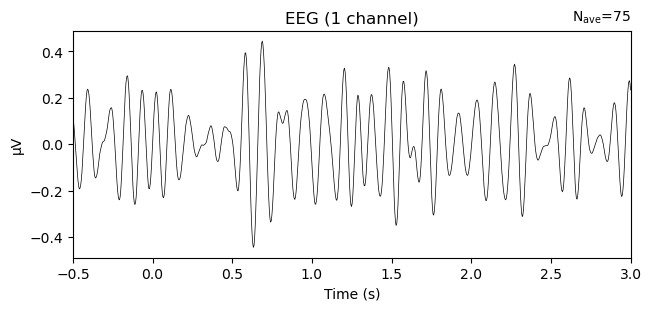

In [568]:
left_MI.plot(picks = center_electrodes, spatial_colors=False);

### Temporal Topology Map

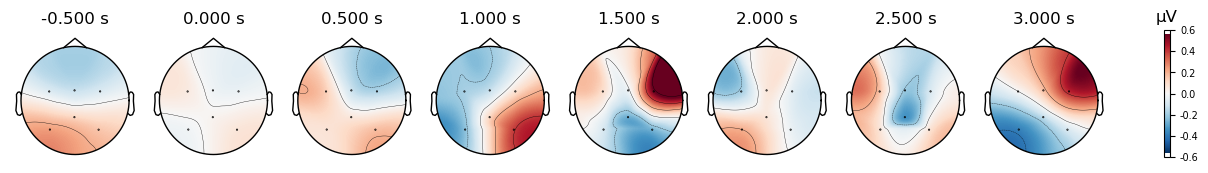

In [569]:
right_MI.plot_topomap(times = [-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]);

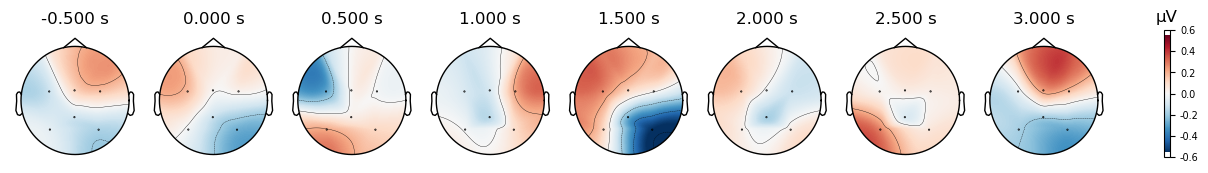

In [570]:
left_MI.plot_topomap(times = [-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]);

### Jointed Plot

No projector specified for this dataset. Please consider the method self.add_proj.


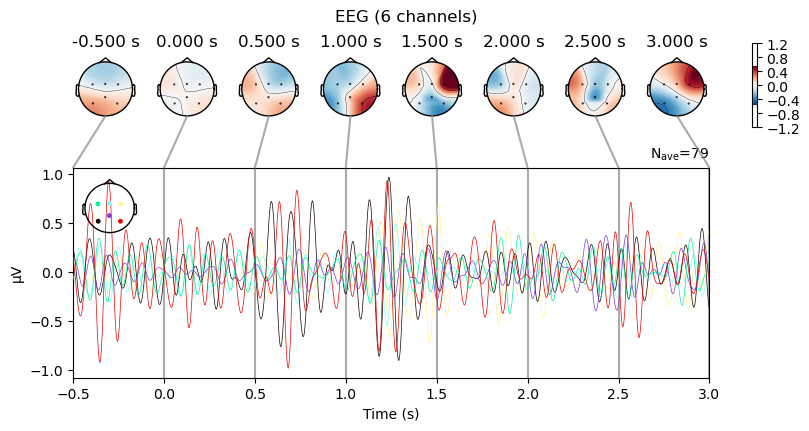

In [571]:
right_MI.plot_joint([-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]);

No projector specified for this dataset. Please consider the method self.add_proj.


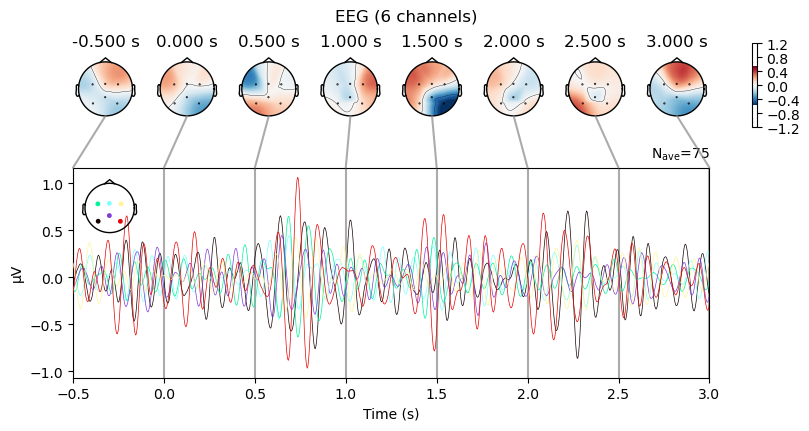

In [572]:
left_MI.plot_joint([-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]);

### Difference Plot

No projector specified for this dataset. Please consider the method self.add_proj.


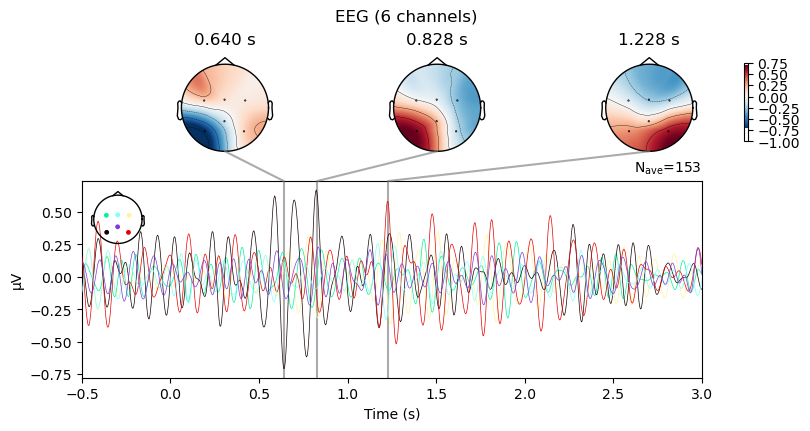

In [573]:
MI_diff = mne.combine_evoked((right_MI,-left_MI), weights='equal')
MI_diff.plot_joint();

## Time-frequency Domain

    Using multitaper spectrum estimation with 7 DPSS windows


Averaging across epochs...


c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


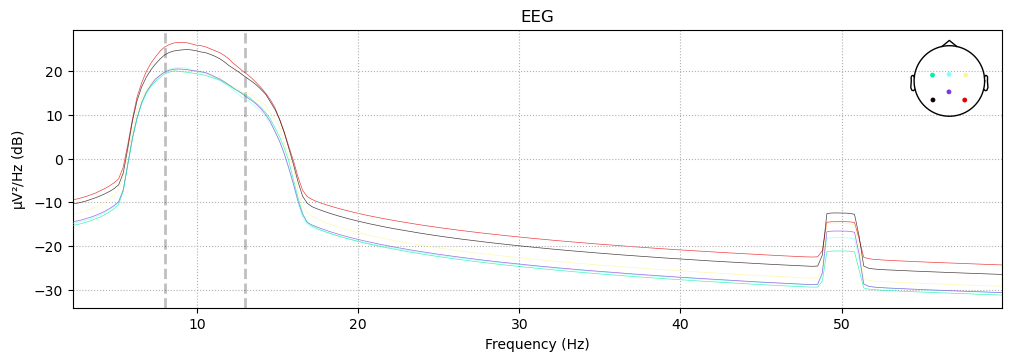

In [574]:
epochs.compute_psd(fmin = 2, fmax = 60).plot();

# Temporary Section

    Using multitaper spectrum estimation with 7 DPSS windows


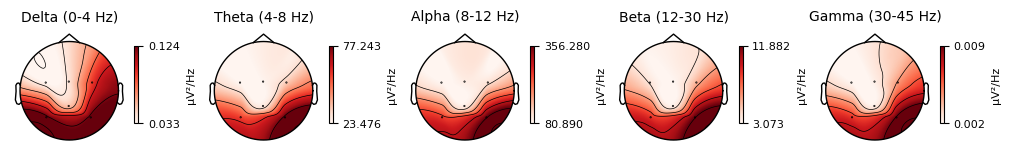

In [575]:
epochs['right'].compute_psd().plot_topomap();

    Using multitaper spectrum estimation with 7 DPSS windows


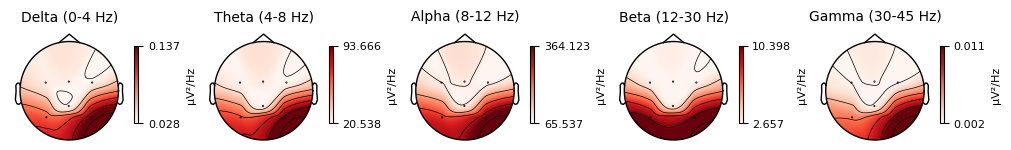

In [576]:
epochs['left'].compute_psd().plot_topomap();

In [577]:
import numpy as np
import scipy


class CSP_ORI:
    def __init__(self, n_components=4):
        self.n_components = n_components

    def fit(self, x, y):
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        if n_classes != 2:
            raise ValueError("n_classes must be 2.")

        covs = []
        for this_class in self.classes:
            x_class = x[y == this_class]
            # Convert data dimention to (channels, epoch * data_point)
            _, n_channels, _ = x_class.shape
            x_class = np.transpose(x_class, [1, 0, 2])
            x_class = x_class.reshape(n_channels, -1)
            cov = np.dot(x_class, x_class.T)
            covs.append(cov)

        # Solve generalized eigenvalue problem
        eig_vals, eig_vecs = scipy.linalg.eigh(covs[0],covs[1])
        for i in range(len(eig_vecs)):
            eig_vecs[i] = eig_vecs[i] / np.linalg.norm(eig_vecs[i])

        i = np.argsort(eig_vals)
        ix = np.empty_like(i)
        ix[1::2] = i[: len(i) // 2]
        ix[0::2] = i[len(i) // 2 :][::-1]

        eig_vecs = eig_vecs[:, ix]
        self.filters = eig_vecs.T
        self.patterns = np.linalg.inv(eig_vecs)
        pick_filters = self.filters[: self.n_components]
        x = np.asarray([np.dot(pick_filters, epoch) for epoch in x])
        x = (x**2).mean(axis=2)
        self.mean = x.mean(axis=0)
        self.std = x.std(axis=0)

    def transform(self, x):
        pick_filters = self.filters[: self.n_components]
        x = np.asarray([np.dot(pick_filters, epoch) for epoch in x])
        x = (x**2).mean(axis=2)
        x -= self.mean
        x /= self.std

        return x

    def fit_transform(self, x, y):
        self.fit(x, y)

        return self.transform(x)

In [578]:
csp = CSP_ORI()
csp.fit(X,Y)

In [579]:
def cov(x_class):
    _, n_channels, _ = x_class.shape
    x_class = np.transpose(x_class, [1, 0, 2])
    x_class = x_class.reshape(n_channels, -1) # Concat all trials
    return np.dot(x_class, x_class.T)

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [580]:
df = epochs.to_data_frame()
df

,time,condition,epoch,C3,Cz,C4,PO7,Pz,PO8,EOG
0,-0.500,left,0,-2.228854,1.404836,1.878078,0.039731,0.341798,-1.338446,-59.505828
1,-0.496,left,0,-2.808831,0.775939,2.092759,0.885697,0.283586,-2.032391,-93.279266
2,-0.492,left,0,-3.148832,0.021760,2.113476,1.740602,0.233269,-2.575941,-6.755828
3,-0.488,left,0,-3.205211,-0.772773,1.924692,2.484209,0.164012,-2.926140,52.626984
4,-0.484,left,0,-2.960056,-1.528539,1.585487,2.972399,0.039331,-3.082978,13.087922
...,...,...,...,...,...,...,...,...,...,...
134899,2.984,right,154,0.153805,-0.405358,-0.799242,0.668477,1.375610,2.481868,223.411954
134900,2.988,right,154,0.332856,-0.591070,-0.617619,0.660177,0.643884,2.674723,204.880704
134901,2.992,right,154,0.509540,-0.716944,-0.369235,0.623261,-0.197498,2.597628,176.161954
134902,2.996,right,154,0.675334,-0.794670,-0.098530,0.576387,-1.080687,2.265233,197.552579


In [581]:
df.describe()

,time,epoch,C3,Cz,C4,PO7,Pz,PO8,EOG
count,134904.000000,134904.000000,134904.000000,134904.000000,134904.000000,134904.000000,134904.000000,134904.000000,134904.000000
mean,1.250000,77.305195,0.002379,0.002079,-0.000242,0.002472,-0.006022,-0.006438,1.653852
std,1.011521,44.727816,1.382132,1.430930,1.461881,2.381359,1.443645,2.818992,48.700680
min,-0.500000,0.000000,-11.772130,-10.120623,-42.021601,-14.090589,-9.725983,-18.066461,-565.848710
25%,0.375000,39.000000,-0.860834,-0.882384,-0.806239,-1.428243,-0.881730,-1.619221,-23.392625
50%,1.250000,77.500000,0.002872,0.000838,-0.002029,0.001416,-0.005771,-0.005821,2.070375
75%,2.125000,116.000000,0.864678,0.890146,0.805969,1.433788,0.868145,1.602609,25.651383
max,3.000000,154.000000,11.398059,8.975682,49.281088,15.660322,9.817231,18.053802,308.576017


C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_42400\744519546.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+alpha)
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_42400\744519546.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+alpha)


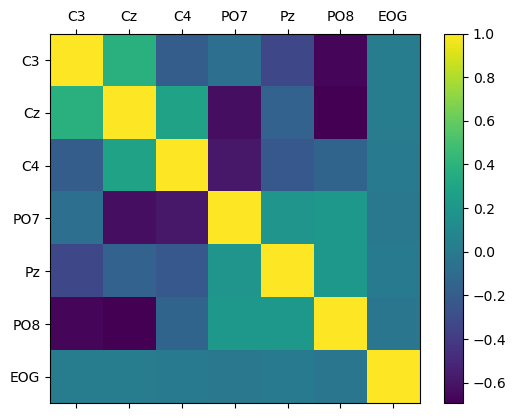

In [582]:
df_numerical = df[epochs.info['ch_names']]

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df_numerical.corr(), interpolation='nearest')
fig.colorbar(cax)

alpha = epochs.info['ch_names']
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

plt.show()

In [583]:
x_right = X[Y==0]
np.linalg.eigvals(cov(x_right))

array([1.58962516e-04, 7.78373977e-07, 4.11911824e-07, 2.10841208e-08,
       4.93087855e-08, 1.29426104e-07, 1.54359281e-07])

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_42400\2090067297.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+alpha)
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_42400\2090067297.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+alpha)


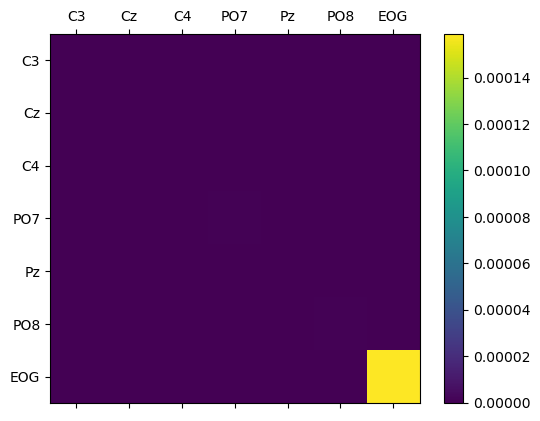

In [584]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cov(x_right), interpolation='nearest')
fig.colorbar(cax)

alpha = epochs.info['ch_names']
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

plt.show()

In [585]:
x_left = X[Y==1]
np.linalg.eigvals(cov(x_left))

array([1.61364787e-04, 7.35373537e-07, 4.02499328e-07, 1.29047903e-07,
       7.25646171e-08, 1.76680639e-08, 3.75558088e-08])

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_42400\1886860997.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+alpha)
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_42400\1886860997.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+alpha)


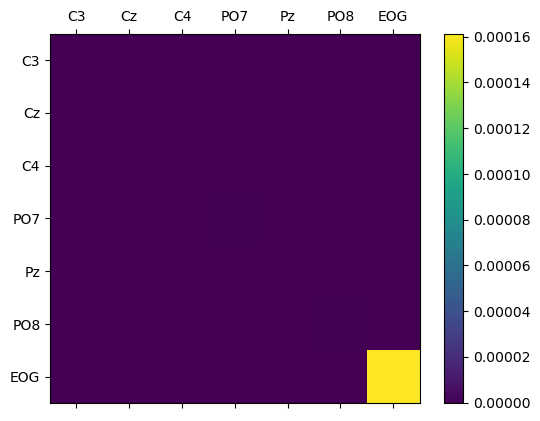

In [586]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cov(x_left), interpolation='nearest')
fig.colorbar(cax)

alpha = epochs.info['ch_names']
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

plt.show()